# Прогнозирование оттока клиентов для фитнес-центра

**Цель исследования:**
- разработать стратегию по удержанию клиентов.

**Ход исследования:**
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.
    
**Описание данных:**
Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
1) Данные клиента за предыдущий до проверки факта оттока месяц:
 - 'gender' — пол;
 - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
 - 'Partner' — сотрудник компании-партнёра клуба;
 - 'Promo_friends — факт первоначальной записи в рамках акции «приведи друга»;
 - 'Phone' — наличие контактного телефона;
 - 'Age' — возраст;
 - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

2) Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
 - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
 - 'Group_visits' — факт посещения групповых занятий;
 - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
 - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
 - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра;
 - 'Churn' — факт оттока в текущем месяце.

## Открытие файлов и изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
clients = pd.read_csv('/datasets/gym_churn.csv')           # откроем файл и взглянем на первые 10 строк

In [3]:
clients.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [4]:
clients.info()        # изучим общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
clients = clients.rename(columns = {'gender': 'Gender'})     # приведем названия столбцов к единому образцу

In [6]:
clients['Month_to_end_contract'] = clients['Month_to_end_contract'].astype('int') # изменим тип данных: количество месяцев - 
clients.head()                                                                    # целое число

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


In [7]:
clients.duplicated().sum()                            # проверим наличие дубликатов

0

### Вывод:
Для прогноза оттока представлены данные о 4 тыс. клиентов. В данных нет пропусков и дубликатов, но обнаружились проблемы с неоднородным наименованием столбцов, а также с типами данных. Проблемы были исправлены.

## Исследовательский анализ данных (EDA)
Посмотрим на датасет и изучим информацию о признаках.

In [10]:
clients.describe()

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


По результатам видим, что мужчин и женщин в выборке примерно одинаковое количество, средний возраст пользователей составляет около 30 лет. Стандартное отклонение от среднего небольшое, что говорит о небольшом разбросе возрастов (от 18 до 41 года).

Большинство пользователей проживает вблизи от фитнес-центра и их телефоны известны компании (об этом говорит среднее по столбцу). По промо-акциям приходит около 30% пользователей, через компании-партнеры  - 48%, то есть последний канал привлечения эффективнее. 

Половина пользователей пользуется абонементом не более 1 месяца и такой же срок указан для большинства как дата окончания контракта. Это свидельствует о том, что лишь небольшая часть пользователей пользуется долговременным абонементом, у остальных он краткосрочный. Эту информацию подтверждает и столбец `Lifetime`, где 75% клиентов не сотрудничает с клубом дольше 5 месяцев. Средняя частота посещений и частота посещений за текущий месяц примерно повторяют друг друга. В отток ушли 26% клиентов.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [11]:
clients.groupby('Churn').mean()

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На этой таблице видим несколько интересных особенностей:
- клиенты, привлеченные в рамках акций или через компании-партнеры, остаются примерно в 1,5-2 раза чаще чем уходят;
- чем дольше  и чаще клиент пользуется фитнес-центром, тем реже он попадает в отток;
- клиенты, которые попадают в отток, реже посещают групповые занятия и в целом меньше пользуются дополнительными услугами фитнес-центра (возможно просто не успевают этого сделать за короткий срок действия абонемента?).

Построим столбчатые гистограммы и диаграммы распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [12]:
# разделим столбцы на две группы: категориальные и числовые
# так графики тоже будут разбиты на две группы и их проще будет рассмотреть

binar_list = ['Gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn']
not_binar_list = ['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 
                  'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

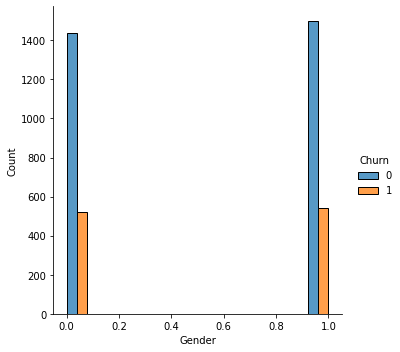

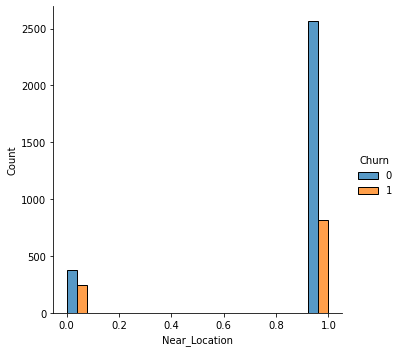

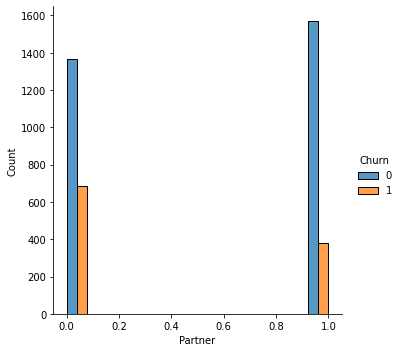

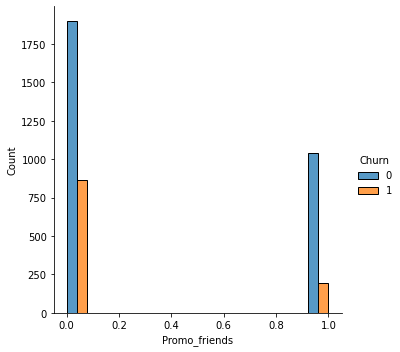

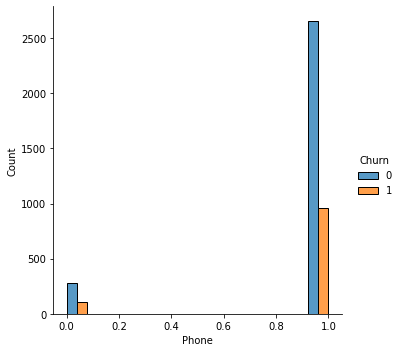

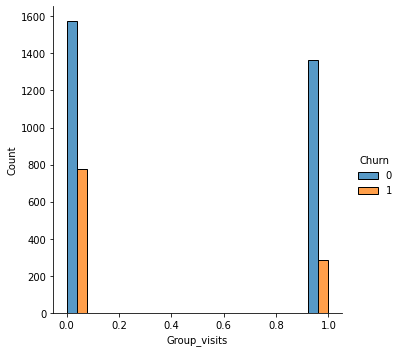

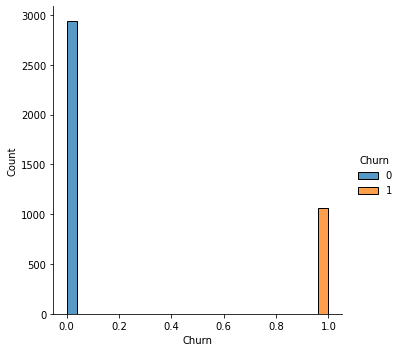

In [13]:
# постороим столбчатые диаграммы для тех признаков, которые содержат бинарные значения, с разбивкой по столбцу "Churn"

for i in binar_list:
    sns.displot(data=clients, x = i, multiple='dodge', hue='Churn')
plt.show()

Диаграммы большей частью подтверждают выводы относительно пола, место проживания, канала привлечения и групповых посещений, сделанные ранее.

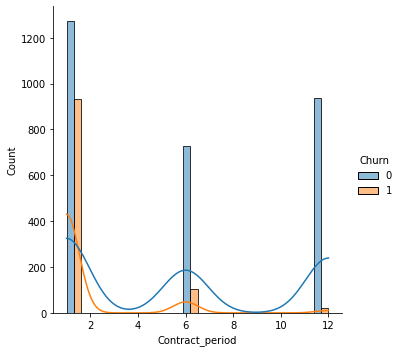

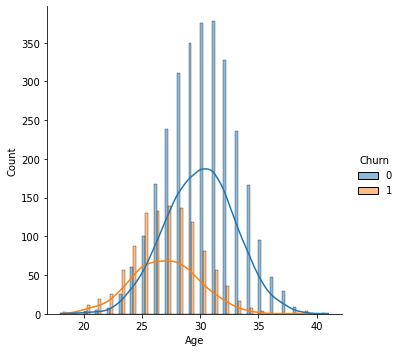

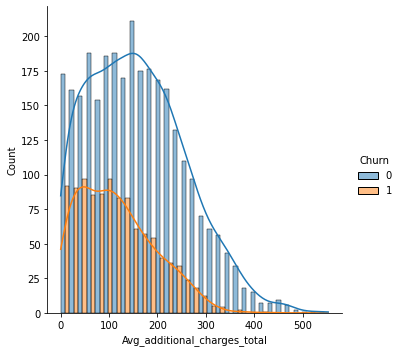

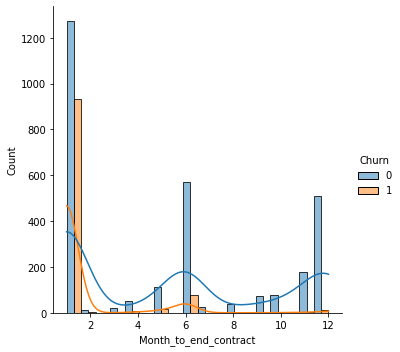

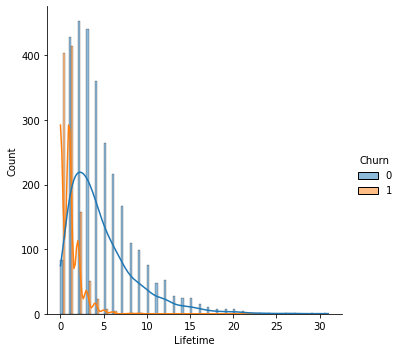

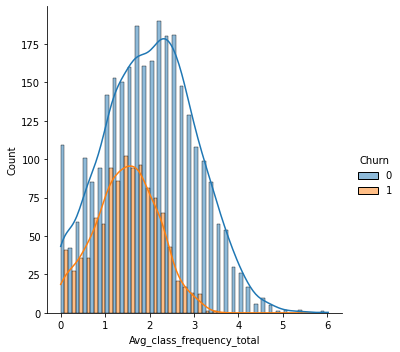

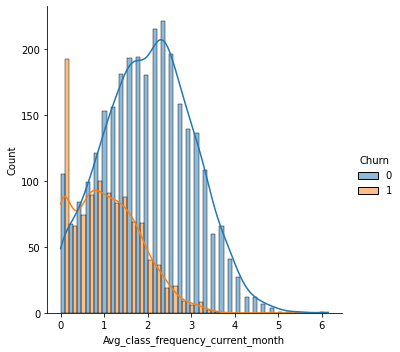

In [14]:
# повторим то же самое для недискретных признаков в сочетании c оценкой плотности ядра

for i in not_binar_list:
    sns.displot(data=clients, x = i, multiple='dodge', hue='Churn', kde = True)
plt.show()

Эти диаграммы дают нам чуть больше сведений:
- для абонементов продолжительностью в 1 месяц доля оттока очень большая, чем длиннее абонемент, тем меньше вероятность оттока;
- распределение на графике возраста близко к нормальному, а клиенты, ушедшие в отток, моложе, чем те, кто остается;
- графики трат на дополнительные услуги скошены вправо, то есть включают небольшое количество крупных трат, которое смещает среднее в большую сторону;
- клиенты, ушедшие в отток, посещают фитнес-центр редко, а в текущем месяце заметен явный выброс в районе 0.

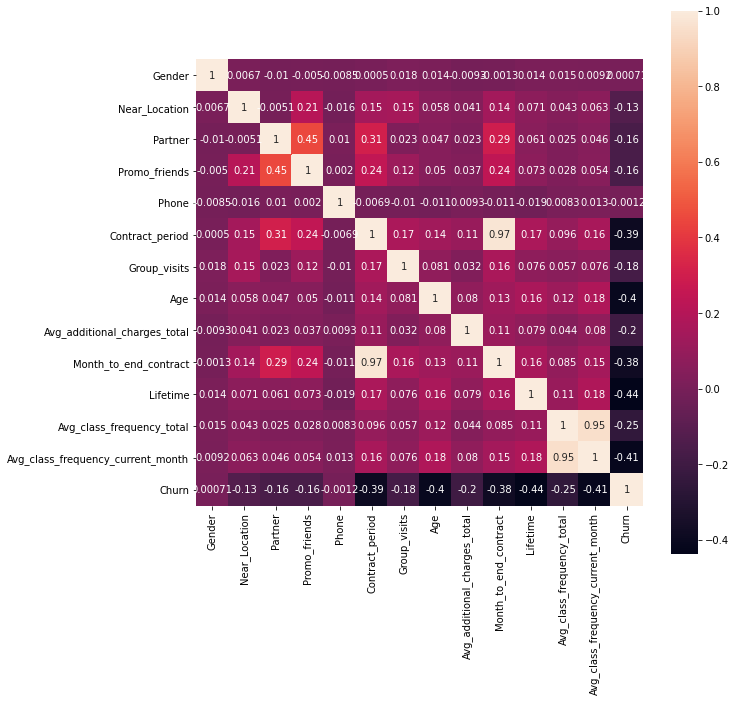

In [15]:
corr_m = clients.corr()                       # создадим матрицу корреляций и нарисуем heatmap по данным без выбросов

plt.figure(figsize = (10,10)) 
sns.heatmap(corr_m, square=True, annot=True)
plt.show()

### Вывод:

На данном шаге изучили представленные данные. Среди признаков представлены категориальные и числовые переменные. Для каждой из групп построили гистограммы и диаграммы распределения, а также нашли взаимную корреляцию между всеми признаками.

По результатам видим, что возраст пользователей колеблется от 18 до 41 года, а среднее значение составляет около 30 лет. Большинство пользователей проживает рядом с фитнес-центром. Из каналов привлечения наиболее эффективно работает сотрудничество  с другими компаниями. А самой высокой популярностью пользуются краткосрочные абонементы. Из всех клиентов, представленных в датасете, в отток ушли 26%.

Относительно прогнозирования оттока можно сказать следующее:
- чем дольше  и чаще клиент пользуется фитнес-центром, тем реже он попадает в отток;
- клиенты, привлеченные в рамках акций или через компании-партнеры, остаются примерно в 1,5-2 раза чаще чем уходят;
- клиенты, которые попадают в отток, реже пользуются дополнительными услугами фитнес-центра;
- клиенты, ушедшие в отток, моложе, чем те, кто остается.

Таким образом, для прогноза важны такие признаки как частота посещений в текущем месяце, срок действия контракта и срок взаимодействия клиента с компанией, а также возраст клиента. Эти выводы подтверждает тепловая карта: эти признаки имеют наиболее высокую корреляцию с целевой переменной `Churn`.

Обучим модели для прогнозирования оттока.

## Mодель прогнозирования оттока клиентов
### Модель логистической регрессии

In [16]:
X = clients.drop(['Churn'], axis=1)                      # разделяем данные на обучающую и валидационную выборки
y = clients['Churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [17]:
def print_all_metrics(y_true, y_pred, y_proba, title):   # создадим функцию для отображения необходимых метрик
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

Поскольку перед нами стоит задача бинарной классификации, то в качестве алгоритма выберем логистическую регрессию. Стоит проверить, как будет работать модель с указанным порогом и без него, так как доля клиентов в оттоке в три раза меньше, чем оставшихся.

In [18]:
lr_model = LogisticRegression(solver='liblinear')               # выберем модель логистической регрессии

threshold = 0.3                                                 # зададим порог, чтобы результаты получились более точными      
lr_model.fit(X_train, y_train)                                  # обучим модель

lr_predictions = lr_model.predict(X_test)                       # сделаем прогноз
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]         # получим вероятность оттока клиента

In [19]:
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.84


In [20]:
custom_predictions = [0 if i < threshold else 1 for i in lr_probabilities]   # посчитаем метрики с учетом порога

In [21]:
print_all_metrics(
    y_test,
    custom_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии с учетом порога:')

Метрики для модели логистической регрессии с учетом порога:
	Accuracy: 0.91
	Precision: 0.79
	Recall: 0.91


Мы добились, что доля правильных ответов понизилась, равно как и доля правильных ответов среди клиентов, уходящих в отток. Зато благодаря балансу классов удалось повысить количество найденных клиентов с высокой вероятностью ухода. Но первая модель все-таки работает лучше. 

### Модель случайного леса

In [22]:
rf_model = RandomForestClassifier(n_estimators = 100)       # для сравнения выберем модель случайного леса

rf_model.fit(X_train, y_train)                              # обучим модель

rf_predictions = rf_model.predict(X_test)                   # сделаем прогноз
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]     # получим вероятность оттока клиента для тестовой выборки

In [23]:
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.82


Качество модели логистической регрессии немного превосходит модель случайного леса. 

### Вывод:
Судя по метрикам, лучше всего работает модель логистической регрессии без указания порога.

## Кластеризация клиентов

In [24]:
sc = StandardScaler()                                     # стандартизируем данные
x_sc = sc.fit_transform(clients)

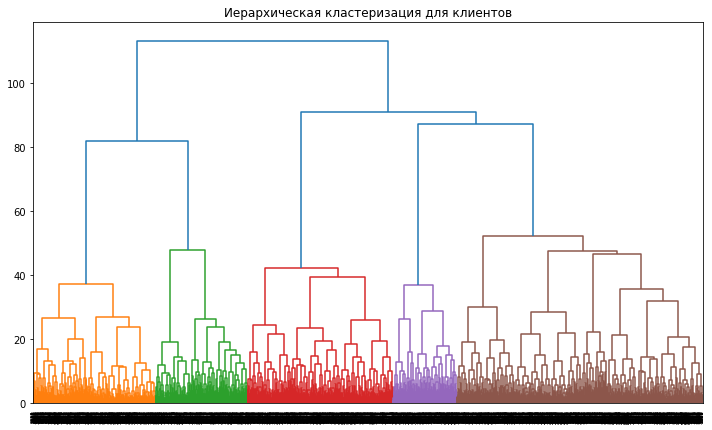

In [25]:
linked  = linkage(x_sc, 'ward')                           # нарисуем дендрограмму
fig = plt.figure(figsize=(12, 7))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для клиентов')
plt.show()

Судя по набору цветов на дендрограмме данные имеет смысл делить на 5 кластеров.

In [26]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)                                   # применяем алгоритм к данным и формируем вектор кластеров 

In [27]:
clients['cluster_km'] = labels

In [28]:
mean_by_clusters = clients.groupby('cluster_km').mean()      # выводим статистику по средним значениям признаков по кластеру
mean_by_clusters

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.503676,0.000000,0.459559,0.075368,0.917279,2.069853,0.211397,28.522059,132.741216,1.950368,2.757353,1.706629,1.515890,0.450368
1,0.492829,0.936115,0.764016,0.534550,0.919166,10.447197,0.516297,29.962190,161.853561,9.477184,4.833116,2.788103,2.786919,0.007823
2,0.507917,1.000000,0.323995,0.213155,0.903776,1.546894,0.287454,26.926918,113.173051,1.500609,1.031669,1.449720,1.037592,0.961023
3,0.521186,0.996610,0.282203,0.208475,0.904237,1.882203,0.452542,30.237288,157.988625,1.794915,4.923729,2.203432,2.207359,0.003390
4,0.518895,0.968023,0.744186,0.526163,0.873547,8.859012,0.534884,29.728198,162.907495,8.155523,4.411337,0.957744,0.943967,0.024709


По данной таблице можно заметить, что больше всего склонны к оттоку посетители, которые вошли в **1-ый кластер**. Они отличаются от остальных небольшим процентом привлеченных по промо-акциям или через компании-партнеры, самым маленьким периодом действия контракта и низкой посещаемостью групповых занятий. Самый низкий отток демонстрирует **3-ий кластер**, который включает клиентов, многие из которых живут поблизости и были привлечены через компании-партнеры. Они в среднем выбирают абонемент от 3 месяцев и активно пользуются услугами фитнес-центра уже продолжительное время.

Построим распределения признаков для кластеров.

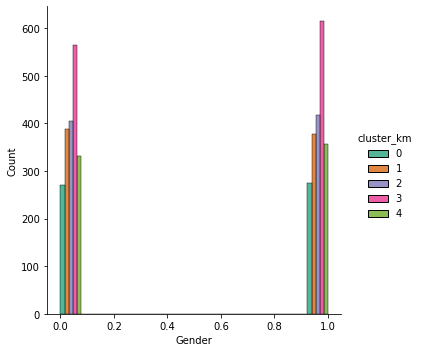

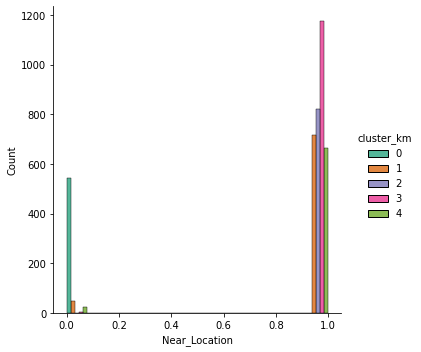

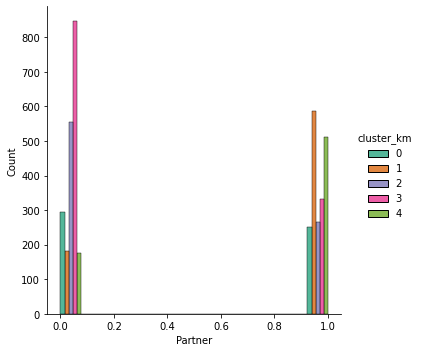

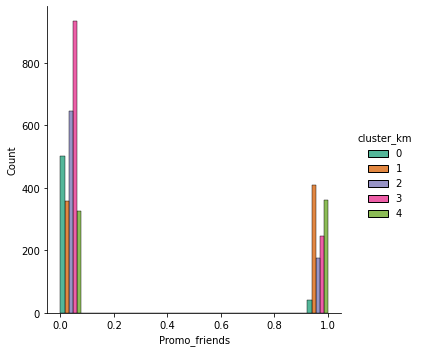

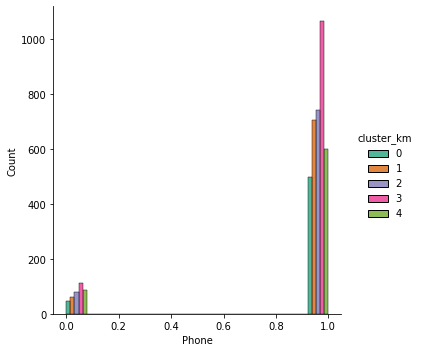

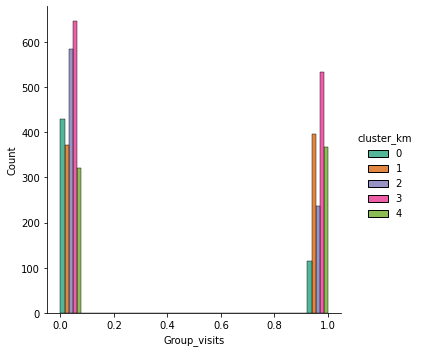

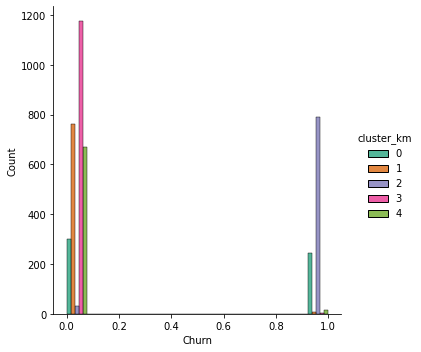

In [29]:
for i in binar_list:
    sns.displot(data=clients, x = i, multiple='dodge', hue='cluster_km', palette = 'Dark2')
plt.show()

На последнем графике видно, что 1-ый кластер почти полностью ушел в отток, а также незначительная часть 4-го.

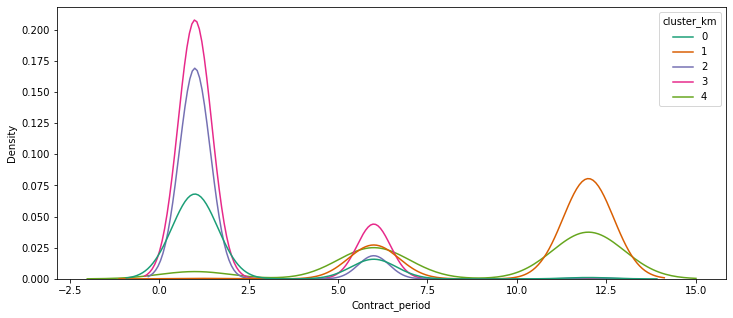

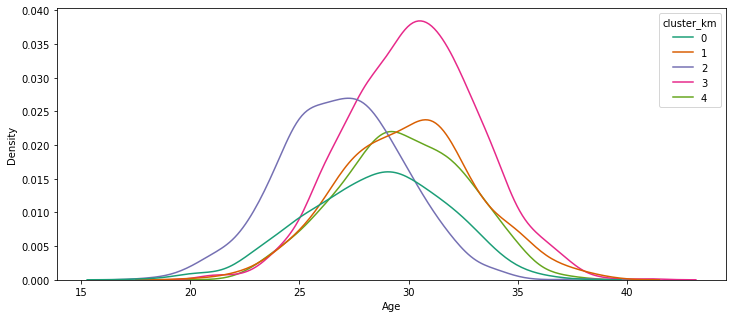

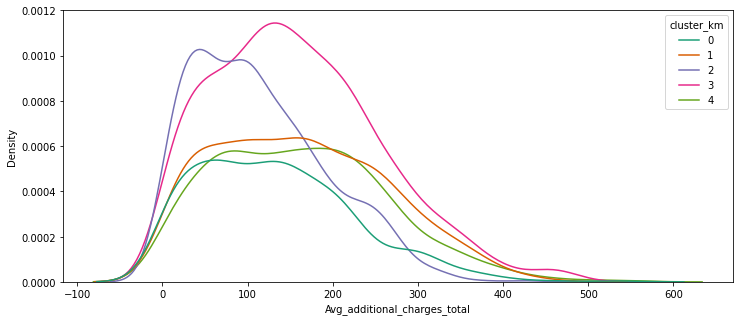

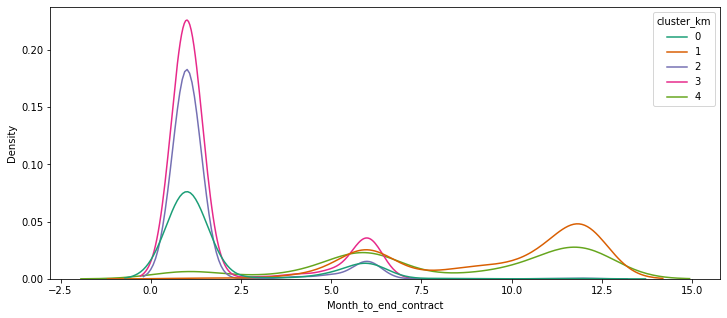

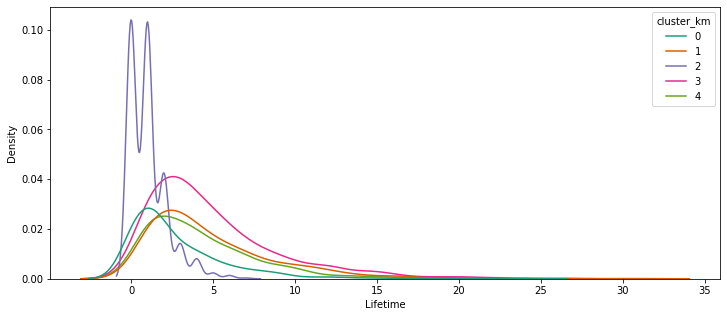

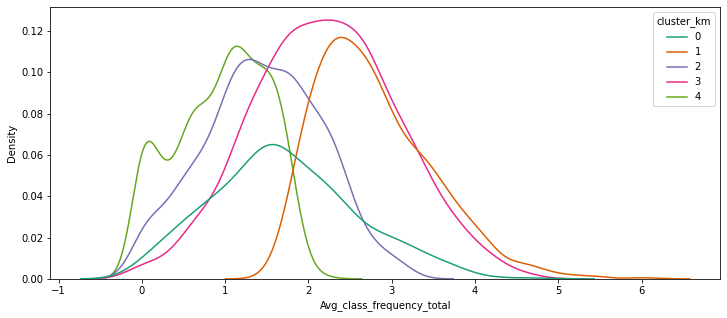

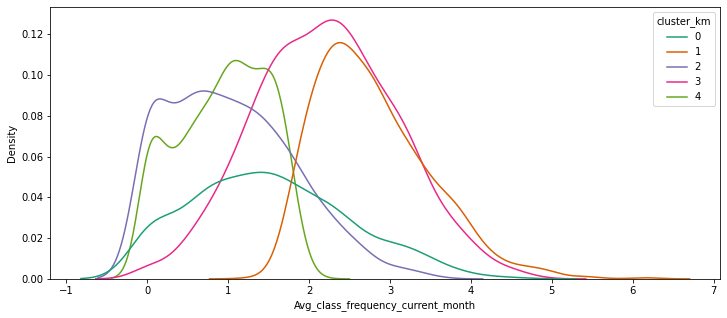

In [30]:
for i in not_binar_list:
    fig = plt.figure(figsize=(12, 5))
    sns.kdeplot(data=clients, x = i, multiple='layer', hue='cluster_km', palette='Dark2')
plt.show()

### Вывод:
На основе кластеризации с использованием алгоритма K-Means можем сделать вывод, что хуже всего удерживаются новые клиенты, которые приобрели абонемент на 1 месяц без скидок и компенсаций. Их возраст в среднем на несколько лет меньше, чем у постоянных клиентов, а также они реже склонны посещать групповые занятия и приобретать дополнительные услуги. Возможно, решение о покупке принимается такими клиентами спонтанно, под влиянием желания "начать новую жизнь с понедельника", а после нескольких посещений энтузиазм пропадает.

Клиенты, которые, наоборот, приобретают абонементы длительностью от 3 месяцев, пользуются скидками или льготами партнеров, а также имеют длительный опыт взаимодействия с фитнес-центром, уходят в отток значительно реже.

## Общие выводы и рекомендации:
Большинство клиентов фитнес-центра составляют посетители, проживающие неподалеку от него. Средний возраст клиента составляет около 29 лет и варьируется в пределах +/- 10 лет. Доля оттока составляет чуть больше четверти посетителей.

Как правило, занятия бросают те, кто приобретает краткосрочные абонементы под влиянием момента, но за месяц не успевает оценить преимуществ фитнес-центра или почувствовать результата/удовольствия от занятий. Средний возраст таких клиентов составляет около 26 лет, они не пользуются скидками и привилегиями, а также избегают использования дополнительных услуг и групповых занятий (возможно, в целях экономии или из-за плохой осведомленности). В связи с этим, предлагаем следующие меры попредотвращению оттока кллиентов:
1) Организовать промо-акции конкретно для новичков. Исследование показало, что клиенты, привлеченные в рамках акций покидают клуб в 1,5-2 раза реже.
2) Стимулировать продление абонемента, так как за срок от 3 месяцев формируется лояльность к конкретному заведению.
3) Организовать экскурсии и пробные занятия для новичков с целью познакомить их с групповыми тренировками и дополнительными услугами центра.
4) Промо-акции имеет смысл проводить для жителей близлежащих районов: необходимость долго добираться до спортзала не стимулирует продолжать занятия. Самым простым и доступным каналом кажется телефон: данные о номерах хранятся почти для каждого клиента.
5) Возможно, ориентация в ходе рекламных компаний на более молодую аудиторию сможет дать свои плоды. Пока клиенты, уходящие в отток, моложе остающихся.